<a href="https://colab.research.google.com/github/raiyan-chowdhury/cifar-10-classifier/blob/main/CIFAR_10_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Raiyan Chowdhury

Student ID: 200354875

---

# ECS659U - Coursework

* Pipeline for training a model:
  1. Read the dataset and create the appropriate dataloaders.
  1. Create and initialise the model.
  1. Create the loss and the optimiser.
  1. Create the training function.
  1. Train and evaluate the model.

---

## Reference for the CIFAR-10 dataset report

Krizhevsky, A. (2009). *Learning multiple layers of features from tiny images*. Tech Report, Chapter 3. Available at: [http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) (Accessed: 14 March 2024).

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
# 1: Read dataset and create dataloaders

# Convert and normalise the images to tensors
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])
])

# Import the dataset and dataloader
datasets = torchvision.datasets
data = torch.utils.data

# Load training set
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)

# Load test set
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = data.DataLoader(testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12823068.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# 2: Create the model
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Block, self).__init__()
        # Spatial average pooling layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Flatten layer
        self.Fltn = nn.Flatten()

        # MLP to predict weights for convolutional layers
        self.fc1 = nn.Linear(in_channels, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, 2)

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(2, 2)

        # Dropout layers for regularisation of convolutional layers
        self.dropout1 = nn.Dropout(0.45)
        self.dropout2 = nn.Dropout(0.35)

    def forward(self, x):
        # Calculate spatial average pool
        out = self.avg_pool(x)

        # Flatten the output
        out = self.Fltn(out)

        out = self.fc1(out)
        out = self.bn_fc1(out)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.bn_fc2(out)
        out = self.relu(out)

        # Last fully connected layer to predict weights for convolutional layers
        out = self.fc3(out)

        # Apply ReLU to ensure non-negative weights
        weights = self.relu(out)

        # First convolutional layer
        out1 = self.conv1(x)
        out1 = self.bn1(out1)
        out1 = self.relu(out1)
        out1 = self.max_pool(out1)
        out1 = self.dropout1(out1)

        # Second convolutional layer
        out2 = self.conv2(x)
        out2 = self.bn2(out2)
        out2 = self.relu(out2)
        out2 = self.max_pool(out2)
        out2 = self.dropout2(out2)

        # Combine the two convolutional layers with weighted sums
        out = weights[:, 0].view(-1, 1, 1, 1) * out1 + \
              weights[:, 1].view(-1, 1, 1, 1) * out2

        return out

class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        # Four blocks in the backbone
        self.block1 = Block(3, 128)
        self.block2 = Block(128, 256)
        self.block3 = Block(256, 256)
        self.block4 = Block(256, 256)

    def forward(self, x):
        # Forward pass through each block
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        return out

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # Spatial average pooling layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Flatten layer
        self.Fltn = nn.Flatten()

        # MLP
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

        self.relu = nn.ReLU(inplace=True)

        # Batch normalization layers for regularisation
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)

    def forward(self, x):
        # Calculate spatial average pool
        out = self.avg_pool(x)

        # Flatten the output
        out = self.Fltn(out)

        # MLP with batch normalization
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # Output layer for producing raw scores/logits for 10 classes
        out = self.fc3(out)

        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Instantiate backbone and classifier
        self.backbone = Backbone()
        self.classifier = Classifier()

    def forward(self, x):
        # Forward pass through backbone and classifier
        out = self.backbone(x)
        out = self.classifier(out)
        return out

In [ ]:
# 3: Create the loss and optimizer
model = CNN()
loss = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)

In [ ]:
# 4: Create the training function
def train(model, trainloader, loss, optimizer, num_epochs):
    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_test_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            l = loss(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            # Accumulate training loss
            running_train_loss += l.item()

            # Calculating training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate and store training accuracy and loss for this epoch
        train_accuracy = correct_train / total_train
        train_accuracy_history.append(train_accuracy)
        train_loss_history.append(running_train_loss / len(trainloader))

        # Evaluating test accuracy and loss
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)

                # Calculate testing loss
                l = loss(outputs, labels)
                running_test_loss += l.item()

                # Calculate testing accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        # Calculate and store testing accuracy and loss for this epoch
        test_accuracy = correct_test / total_test
        test_accuracy_history.append(test_accuracy)
        test_loss_history.append(running_test_loss / len(testloader))

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {train_loss_history[-1]:.4f}, '
              f'Testing Loss: {test_loss_history[-1]:.4f}, '
              f'Training Accuracy: {train_accuracy * 100:.2f}%, '
              f'Test Accuracy: {test_accuracy * 100:.2f}%')

    print('Finished Training')
    return train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history

In [ ]:
# 5: Train the model
num_epochs = 30
train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history = train(model, trainloader, loss, optimizer, num_epochs)

Epoch [1/30], Training Loss: 2.0804, Testing Loss: 1.8811, Training Accuracy: 21.23%, Test Accuracy: 29.94%
Epoch [2/30], Training Loss: 1.4030, Testing Loss: 1.2249, Training Accuracy: 48.63%, Test Accuracy: 55.98%
Epoch [3/30], Training Loss: 1.1114, Testing Loss: 1.0073, Training Accuracy: 60.28%, Test Accuracy: 64.84%
Epoch [4/30], Training Loss: 0.9666, Testing Loss: 0.8461, Training Accuracy: 65.65%, Test Accuracy: 70.93%
Epoch [5/30], Training Loss: 0.8725, Testing Loss: 0.7889, Training Accuracy: 69.28%, Test Accuracy: 72.59%
Epoch [6/30], Training Loss: 0.8010, Testing Loss: 0.7605, Training Accuracy: 71.85%, Test Accuracy: 73.37%
Epoch [7/30], Training Loss: 0.7553, Testing Loss: 0.6942, Training Accuracy: 73.40%, Test Accuracy: 75.67%
Epoch [8/30], Training Loss: 0.7088, Testing Loss: 0.6471, Training Accuracy: 75.15%, Test Accuracy: 77.41%
Epoch [9/30], Training Loss: 0.6657, Testing Loss: 0.6262, Training Accuracy: 76.76%, Test Accuracy: 77.87%
Epoch [10/30], Training Loss

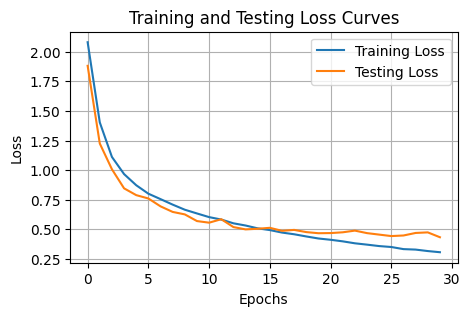

In [ ]:
# Plot the loss curves
plt.figure(figsize=(5, 3))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

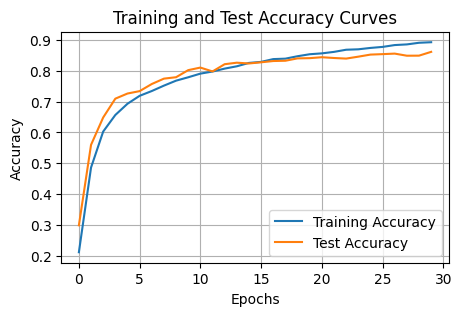

In [ ]:
# Plot the accuracy curves
plt.figure(figsize=(5, 3))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curves')
plt.legend()
plt.grid(True)
plt.show()